# Hyper-Graph based appraoch

In [ ]:
!pip install torch torchvision transformers datasets tqdm matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import re, string
import networkx as nx
import matplotlib.pyplot as plt
import re, string
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


## Loading our dataset only 400 out of 74k cause of complexity

---



In [ ]:
dataset = load_dataset("lucadiliello/newsqa", split="validation[:400]")

print("Example:")
print(dataset[0])

Example:
{'context': "(CNN) -- What could be more powerful than the tears of a Native American Indian?\n\n\n\nWax on, wax off: Does it make you want to save the rainforests?\n\n\n\nIron Eyes Cody was the face of the Keep American Beautiful campaign of 1971 whose tears marked the plight of the environment, but more importantly kept the problems of pollution in the minds of millions.\n\n\n\nFrom teary Native Americans to witty skits or doom-ladened eco-horror scenarios, the environmental campaign video then has long been a powerful tool for environmental groups to spread their message and raise pubic attention.\n\n\n\nThe rise of YouTube and other video sharing web sites has now meant that individuals can broadcast their own eco-awareness messages and form their own social action networks.\n\n\n\nBut what makes a good video and how much impact do they have? Is it better to be funny or shocking? When you see Harrison Ford getting his chest waxed, do you immediately think about saving the 

## Pre-trained tokenizer from bert

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def encode_example(example):
    context = example["context"]
    question = example["question"]
    answer_text = example["answers"][0] if isinstance(example["answers"], list) else example["answers"]

    enc = tokenizer(
        question,
        context,
        truncation=True,
        padding="max_length",
        max_length=512,
        return_offsets_mapping=True,
        return_tensors="pt"
    )

    start_char = example["labels"][0]["start"][0]
    end_char = example["labels"][0]["end"][0]
    offsets = enc["offset_mapping"][0]

    start_positions = [0]
    end_positions = [0]
    for i, (start, end) in enumerate(offsets):
        if start <= start_char < end:
            start_positions = [i]
        if start < end_char <= end:
            end_positions = [i]

    return {
        "encoding": enc,
        "start_positions": torch.tensor(start_positions[0]),
        "end_positions": torch.tensor(end_positions[0]),
        "answer_text": answer_text
    }


In [ ]:
data_list = [encode_example(example) for example in dataset]
print("Encoded examples:", len(data_list))

Encoded examples: 4212


## basic definitions for normilizing, f1, em

In [ ]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = " ".join(text.split())
    return text

def compute_f1(pred, truth):
    pred_tokens = normalize_text(pred).split()
    truth_tokens = normalize_text(truth).split()
    common = set(pred_tokens) & set(truth_tokens)
    if len(common) == 0:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    return 2 * precision * recall / (precision + recall)

# Modify evaluate_model to build and pass H_matrix
def evaluate_model(model, data_list, tokenizer, n_sample=50, device="cuda"):
    model.to(device)
    model.eval()
    total_em, total_f1 = 0, 0

    # Explicitly handle n_sample=None for slicing
    dataset_subset = data_list[:n_sample] if n_sample is not None else data_list[:]


    for ex in tqdm(dataset_subset, desc="Evaluating"):
        enc = ex["encoding"]
        with torch.no_grad():
            # Assuming model is HyperQA, expects input_ids and attention_mask
            # Ensure input_ids and attention_mask are correctly passed without extra dimensions
            # Use the device argument directly
            input_ids = enc["input_ids"].to(device)
            attention_mask = enc["attention_mask"].to(device)

            # Need to get context and question from the original dataset example
            # This assumes data_list order matches dataset order, which might not be robust.
            # A better approach would be to store the original dataset index in the encoded example.
            # For now, let's assume the order is the same for simplicity.
            original_example_index = data_list.index(ex) # This is inefficient in a loop
            context = dataset[original_example_index]["context"]
            question = dataset[original_example_index]["question"]

            # Build hypergraph for the example
            H_matrix, _ = build_hypergraph(context, question, tokenizer)
            H_matrix = H_matrix.to(device) # Move H_matrix to the device


            # Model call should not have unsqueeze(0) if batch size is 1
            # If enc["input_ids"] is already (1, T), pass it directly
            # If enc["input_ids"] is (T), it needs unsqueeze(0) to be (1, T)
            # Based on tokenizer return_tensors="pt", shape is (1, T)
            # So, pass directly, and pass H_matrix
            s_logits, e_logits = model(input_ids=input_ids, attention_mask=attention_mask, H_matrix=H_matrix)


        # Get predicted start and end tokens
        # Assuming model output is (1, T)
        s = torch.argmax(s_logits[0]).item() # Access batch dimension 0
        e = torch.argmax(e_logits[0]).item() # Access batch dimension 0


        tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0][s:e+1])
        pred_text = tokenizer.convert_tokens_to_string(tokens)

        # Assuming 'answer_text' is present in the example dictionary
        # Based on encode_example in S4F5rFJ8XzJ-, 'answer_text' is present
        truth = ex["answer_text"]

        total_em += int(normalize_text(pred_text) == normalize_text(truth))
        total_f1 += compute_f1(pred_text, truth)

    # Calculate number of samples actually evaluated
    n_evaluated = len(dataset_subset) if n_sample is not None else len(data_list)


    return total_em / max(1, n_evaluated), total_f1 / max(1, n_evaluated)

## Definng the main hyperQA architecture

In [ ]:
class HyperGCN(nn.Module):
    def __init__(self, in_features, out_features, alpha=0.1):
        super().__init__()
        self.alpha = alpha
        self.linear = nn.Linear(in_features, out_features)


    def forward(self, X, H):
        # X: input token representations (B, T, H_features)
        # H: incidence matrix (T, num_hyperedges)

        H = H.to(X.device)

        B, T, H_features = X.shape
        num_hyperedges = H.shape[1]

        X_prime = self.linear(X) # (B, T, out_features)

        # --- HyperGCN-like Message Passing ---

        # 1. Node features to Hyperedge features (Aggregation)
        Hyperedge_features = torch.einsum('bih,ij->bjh', X_prime, H)

        # --- Normalization (Simplified HyperGCN style) ---
        node_degrees = torch.sum(H, dim=1) # Shape (T,)
        hyperedge_degrees = torch.sum(H, dim=0) # Shape (num_hyperedges,)

        node_degrees[node_degrees == 0] = 1e-5
        hyperedge_degrees[hyperedge_degrees == 0] = 1e-5

        inv_sqrt_dv = torch.diag(torch.pow(node_degrees, -0.5)) # Shape (T, T)
        inv_de = torch.diag(torch.pow(hyperedge_degrees, -1.0)) # Shape (num_hyperedges, num_hyperedges)

        # Standard HyperGCN propagation: Dv^-1/2 * H * De^-1 * H.T * Dv^-1/2 * X_in
        X_hat = torch.einsum('ii,bih->bih', inv_sqrt_dv, X_prime)
        H_msg = torch.einsum('ji,bjh->bih', H.t(), X_hat)
        H_msg_norm = torch.einsum('jj,bjh->bjh', inv_de, H_msg)
        Node_updates = torch.einsum('ij,bjh->bih', H, H_msg_norm)
        X_hg = torch.einsum('ii,bih->bih', inv_sqrt_dv, Node_updates)

        return X_hg

In [ ]:
class HyperGraphQAModel(nn.Module):
    def __init__(self, hidden_size=768, alpha=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained("bert-base-uncased")
        # Define individual SimpleHypergraphLayers explicitly
        self.hg_layer1 = HyperGCN(alpha)
        self.hg_layer2 = HyperGCN(alpha)
        self.hg_layer3 = HyperGCN(alpha)
        self.hg_layer4 = HyperGCN(alpha) # Add 3 more layers

        self.start_head = nn.Linear(hidden_size, 1)
        self.end_head = nn.Linear(hidden_size, 1)

    # Modify forward to accept H_matrix
    def forward(self, input_ids, attention_mask, H_matrix):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        X = outputs.last_hidden_state  # (B, T, H_features)

        # Apply the hypergraph layers sequentially
        X_hg = self.hg_layer1(X, H_matrix)
        X_hg = self.hg_layer2(X_hg, H_matrix)
        X_hg = self.hg_layer3(X_hg, H_matrix)
        X_hg = self.hg_layer4(X_hg, H_matrix)


        # Use the enhanced representations for prediction heads
        start_logits = self.start_head(X_hg).squeeze(-1) # (B, T)
        end_logits = self.end_head(X_hg).squeeze(-1)   # (B, T)

        return start_logits, end_logits

##Building the Hypergraph

## 🔺 HyperGCN Message Passing Formula

For a batch of token embeddings \( X \in \mathbb{R}^{B \times T \times d} \)  
and a hypergraph incidence matrix \( H \in \{0,1\}^{B \times T \times E} \):

---

### 1️⃣ Compute degrees
$$
D_v = \mathrm{diag}(H \mathbf{1}_E), \quad
D_e = \mathrm{diag}(H^{\top} \mathbf{1}_T)
$$

---

### 2️⃣ Normalize incidence matrices
$$
H_{\text{norm,v}} = H D_v^{-1}, \quad
H_{\text{norm,e}} = H D_e^{-1}
$$

---

### 3️⃣ Message passing steps

**Node → Hyperedge aggregation**
$$
Z_e = H_{\text{norm,e}}^{\top} X
$$

**Hyperedge → Node propagation**
$$
Z_v = H_{\text{norm,v}} Z_e
$$

**Residual update with transformation**
$$
X' = (1 - \alpha) X + \alpha \, \text{Dropout}(\text{LayerNorm}(Z_v W))
$$

---

### ✅ Compact matrix form
$$
\boxed{
X^{(l+1)} = (1 - \alpha) X^{(l)} +
\alpha \, D_v^{-1} H D_e^{-1} H^{\top} X^{(l)} W^{(l)}
}
$$

where:

- \( D_v \): node degree matrix  
- \( D_e \): hyperedge degree matrix  
- \( W^{(l)} \): learnable linear projection  
- \( \alpha \in [0,1] \): residual mixing coefficient  

---

This represents a **two-hop hypergraph convolution**, where each node aggregates information from all hyperedges it belongs to, enabling **group-wise reasoning** over token relationships.


In [ ]:
def build_hypergraph(context, question, tokenizer, window_size=3, max_length=512):
    enc = tokenizer(question, context, truncation=True, padding="max_length",
                         max_length=max_length, return_tensors="pt", return_token_type_ids=True)
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])
    token_type_ids = enc["token_type_ids"][0]
    n_tokens_padded = max_length

    edges = []
    for i in range(n_tokens_padded - window_size + 1):
         if i >= 0:
             edges.append(list(range(i, i + window_size)))

    question_token_indices = [i for i, type_id in enumerate(token_type_ids) if type_id == 0 and tokens[i] not in ['[CLS]', '[SEP]']]
    if question_token_indices:
        edges.append(question_token_indices)

    # incidence matrix
    n_edges = len(edges)
    H = torch.zeros((n_tokens_padded, n_edges))
    for e_id, nodes in enumerate(edges):
        for n in nodes:
            if n < n_tokens_padded:
                H[n, e_id] = 1
    return H, tokens


## Visualizing  the hyper graph

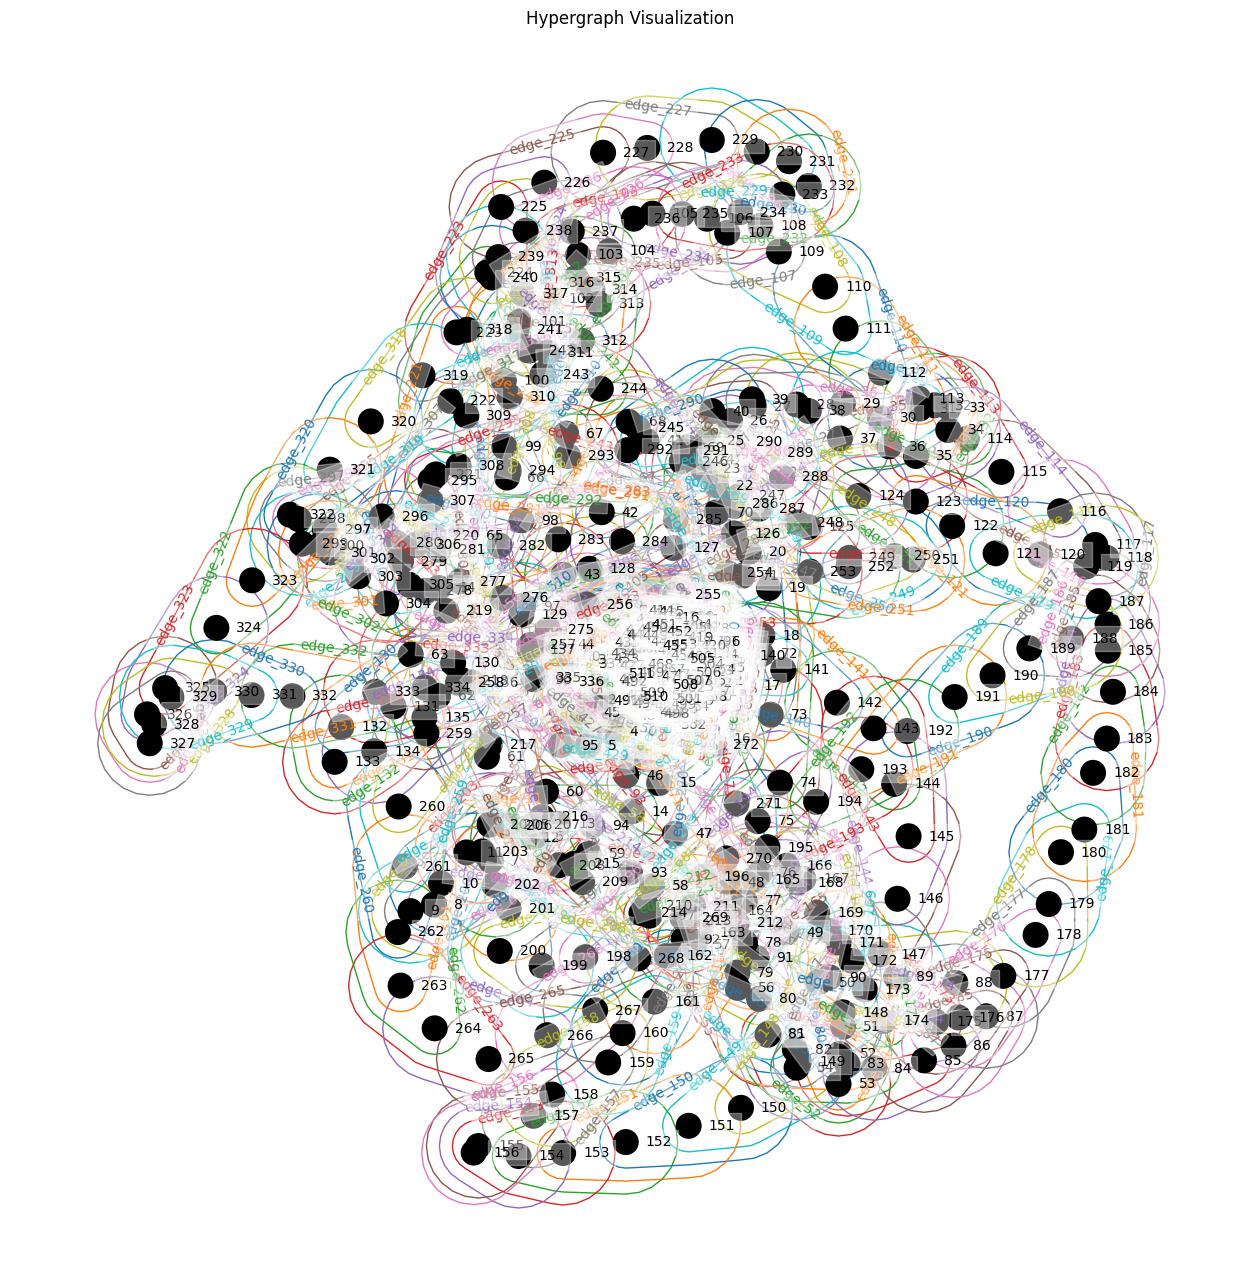

In [ ]:
import hypernetx as hnx
import numpy as np
from hypernetx import draw
import matplotlib.pyplot as plt

H_numpy = H_matrix.numpy()#lets make our tensor into a numpy

edges_dict = {}#i learnt how to draw graphs from dicts only :(
num_tokens, num_edges = H_numpy.shape
for edge_id in range(num_edges):
    # Find the token indices that belong to this edge
    nodes_in_edge = np.where(H_numpy[:, edge_id] == 1)[0].tolist()
    if nodes_in_edge: # Only add edges that have nodes
        edges_dict[f"edge_{edge_id}"] = nodes_in_edge


H = hnx.Hypergraph(edges_dict)

# Visualize the hypergraph
plt.figure(figsize=(16, 16))
draw(H)
plt.title("Hypergraph Visualization")
plt.show()

## Train Hypergraph model

In [ ]:
model = HyperGraphQAModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(1, 20):
    model.train()
    total_loss = 0
    for ex in tqdm(data_list, desc=f"Training (epoch {epoch})"):
        enc = ex["encoding"]
        input_ids = enc["input_ids"].to(device)
        mask = enc["attention_mask"].to(device)
        s_pos = ex["start_positions"].to(device)
        e_pos = ex["end_positions"].to(device)

        # Build hypergraph for each example
        original_example_index = data_list.index(ex)
        context = dataset[original_example_index]["context"]
        question = dataset[original_example_index]["question"]
        H_matrix, _ = build_hypergraph(context, question, tokenizer)
        H_matrix = H_matrix.to(device)

        # Pass H_matrix to the model
        s_logits, e_logits = model(input_ids=input_ids, attention_mask=mask, H_matrix=H_matrix)
        loss_s = F.cross_entropy(s_logits, s_pos.unsqueeze(0))
        loss_e = F.cross_entropy(e_logits, e_pos.unsqueeze(0))
        loss = (loss_s + loss_e) / 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


    em, f1 = evaluate_model(model, data_list, tokenizer, n_sample=50, device=device)
    print(f"Epoch {epoch}: loss={total_loss/len(data_list):.4f}, EM={em:.3f}, F1={f1:.3f}")



Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 44.90it/s]


Epoch 1: loss=3.5409, EM=0.180, F1=0.274


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.65it/s]


Epoch 2: loss=1.8153, EM=0.380, F1=0.527


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.08it/s]


Epoch 3: loss=0.9273, EM=0.540, F1=0.666


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.59it/s]


Epoch 4: loss=0.6034, EM=0.580, F1=0.640


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.45it/s]


Epoch 5: loss=0.4416, EM=0.620, F1=0.688


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.52it/s]


Epoch 6: loss=0.3571, EM=0.680, F1=0.740


Training (epoch 7):  16%|█████████▏                                                 | 656/4212 [01:16<06:56,  8.55it/s]

KeyboardInterrupt



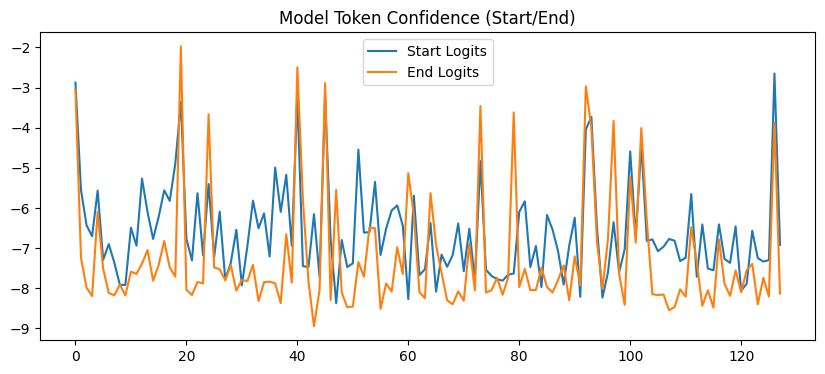

In [ ]:
def visualize_attention(context, question, model, tokenizer):
    enc = tokenizer(question, context, return_tensors="pt", truncation=True, max_length=128)
    input_ids = enc["input_ids"].to(device)
    mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        s_logits, e_logits = model(input_ids, mask)
    s_scores = s_logits[0].cpu().numpy()
    e_scores = e_logits[0].cpu().numpy()
    plt.figure(figsize=(10,4))
    plt.plot(s_scores, label="Start Logits")
    plt.plot(e_scores, label="End Logits")
    plt.legend()
    plt.title("Model Token Confidence (Start/End)")
    plt.show()

first = dataset[0]
visualize_attention(first["context"], first["question"], model, tokenizer)

In [ ]:
example = data_list[0]
enc = example["encoding"]
with torch.no_grad():
    s_logits, e_logits = model(enc["input_ids"].to(device), enc["attention_mask"].to(device))
s, e = torch.argmax(s_logits), torch.argmax(e_logits)
tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0][s:e+1])
pred_text = tokenizer.convert_tokens_to_string(tokens)
print("Question:", dataset[0]["question"])
print("Predicted:", pred_text)
print("Correct:", example["answer_text"])


Question: What will be nominated?
Predicted: three different videos
Correct: three different videos
